In [1]:
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

/home/yinghao.luo@mydre.org/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("PlanTL-GOB-ES/pharmaconer")
dataset = concatenate_datasets([
    dataset["train"],
    dataset["validation"],
    dataset["test"]
])


In [3]:
id2label = dataset.features["ner_tags"].feature.names
entity_spans = defaultdict(list)

def extract_entities(tags):
    entities = []
    start = None
    label = None
    for i, tag in enumerate(tags):
        if tag.startswith("B-"):
            if start is not None:
                entities.append((start, i - 1, label))
            start = i
            label = tag[2:]
        elif tag.startswith("I-") and start is not None and tag[2:] == label:
            continue
        else:
            if start is not None:
                entities.append((start, i - 1, label))
                start = None
    if start is not None:
        entities.append((start, len(tags) - 1, label))
    return entities

for sample in dataset:
    tokens = sample["tokens"]
    tags = [id2label[i] for i in sample["ner_tags"]]
    for start, end, ent_type in extract_entities(tags):
        span = " ".join(tokens[start:end+1])
        entity_spans[ent_type].append(span)

In [4]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * mask_expanded, dim=1)
    sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
    return sum_embeddings / sum_mask

def get_span_embeddings(span_list, model_path, batch_size=32):
    print(f"[INFO] Extracting from: {model_path}")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    model.eval()

    all_embeddings = []
    for i in range(0, len(span_list), batch_size):
        batch = span_list[i:i+batch_size]
        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            output = model(**encoded)
        pooled = mean_pooling(output, encoded["attention_mask"])
        all_embeddings.append(pooled.cpu())
    return torch.cat(all_embeddings, dim=0).numpy()



In [ ]:
max_per_class = 200
filtered_spans = {k: v[:max_per_class] for k, v in entity_spans.items() if len(v) >= 20}

model_path = "bsc-bio-ehr-es/pharmaconer/output_model"
embeddings = {
    label: get_span_embeddings(spans, model_path)
    for label, spans in filtered_spans.items()
}

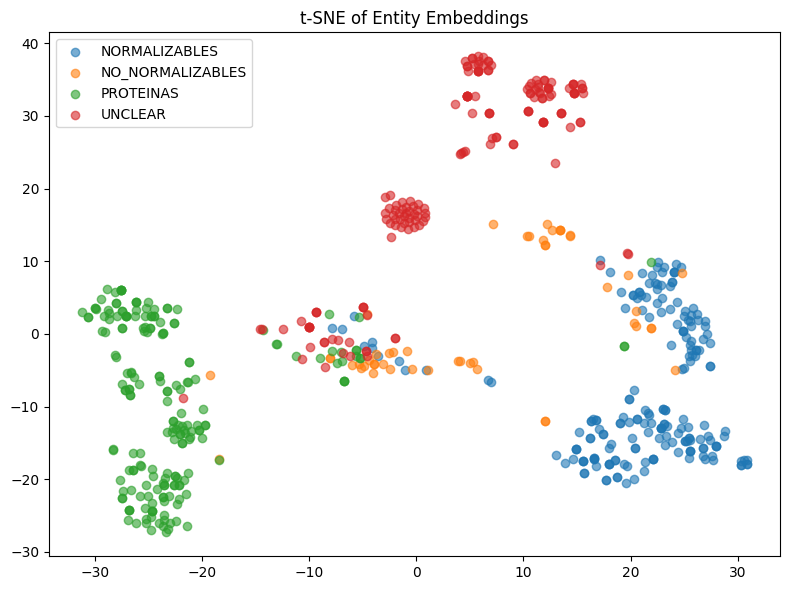

In [22]:
all_vecs = np.vstack(list(embeddings.values()))
all_labels = sum([[label] * len(vecs) for label, vecs in embeddings.items()],[])

tsne = TSNE(n_components = 2, random_state = 42, perplexity = 35)
X_2d = tsne.fit_transform(all_vecs)

plt.figure(figsize=(8, 6))
for label in sorted(set(all_labels)):
    idxs = [i for i, l in enumerate(all_labels) if l == label]
    plt.scatter(X_2d[idxs, 0], X_2d[idxs, 1], label=label, alpha=0.6)
plt.legend()
plt.title("t-SNE of Entity Embeddings")
plt.tight_layout()
# plt.savefig("tsne_pha_ner.png")
plt.show()
